In [1]:
from pathlib import Path
import os
import sys
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import statistics
%matplotlib inline

from keras import layers
from keras import models
from keras import optimizers
from keras.utils import to_categorical
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
# create directories for where data sources are stored. Original source of data can be downloaded here:
# https://www.kaggle.com/sovitrath/sports-image-dataset
parent_dir = Path(os.getcwd()).absolute()
data_dir = os.path.join(parent_dir,'sports_images')
data_path = os.path.join(data_dir,'train/train')
image_labels_path = os.path.join(data_dir,'train_labels.csv')

In [3]:
# create dict of labels and their corresponding numeric representation
labels = {'badminton': 0, 'baseball': 1, 'basketball': 2, 'boxing': 3, 'chess': 4, 'cricket': 5, 'fencing': 6,
          'football': 7, 'formula1': 8, 'gymnastics': 9, 'hockey': 10, 'ice_hockey': 11, 'kabaddi': 12, 
          'motogp': 13, 'shooting': 14, 'swimming': 15, 'table_tennis': 16, 'tennis': 17, 'volleyball': 18,
          'weight_lifting': 19, 'wrestling': 20, 'wwe': 21}

# create a dataframe of the image labels
image_labels = pd.read_csv(image_labels_path)

# map the labels to their corresponding numeric representation
image_labels['label_number'] = image_labels['sports'].map(labels)

# list of just the label numbers
image_labels_numerical = image_labels['label_number']

# create a list of the file names
file = []
for image in image_labels['image']:
    name = image.split('/')[2]
    file.append(name)
    
# create a new column with just the file names
image_labels['file'] = file
    
# create a dict of the files and their corresponding numeric label
file_dict = pd.Series(image_labels.label_number.values,index=image_labels.file).to_dict()

image_labels.head()

,image,sports,label_number,file
0,./train/0.jpg,baseball,1,0.jpg
1,./train/1.jpg,formula1,8,1.jpg
2,./train/2.jpg,fencing,6,2.jpg
3,./train/3.jpg,motogp,13,3.jpg
4,./train/4.jpg,ice_hockey,11,4.jpg


In [46]:
# create a function that loads each image and transforms it into an array fit for modeling
def create_dataset(img_folder, img_width, img_height):
    img_data_array=[]
    
    for file in os.listdir(img_folder):
        if not file.startswith('.'):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(img_height, img_width),interpolation = cv2.INTER_AREA)
            image = np.array(image)
            img_data_array.append([file,image])
        else:
            continue
    
    return img_data_array

In [5]:
# run the image transformation function on the images
image_attributes = create_dataset(data_path, 64, 64)

# create a dataframe of the file name and transformed images
image_df = pd.DataFrame(image_attributes, columns = ['file','image'])
# add a label column of the numeric label for each image
image_df['label'] = image_df['file'].map(file_dict)
image_df.head()

,file,image,label
0,9733.jpg,"[[[43, 26, 15], [43, 26, 15], [84, 46, 16], [1...",1
1,63.jpg,"[[[157, 166, 175], [153, 162, 171], [143, 153,...",0
2,6400.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",6
3,823.jpg,"[[[19, 14, 5], [15, 13, 9], [16, 18, 18], [21,...",5
4,4217.jpg,"[[[64, 145, 126], [66, 147, 127], [70, 149, 12...",13


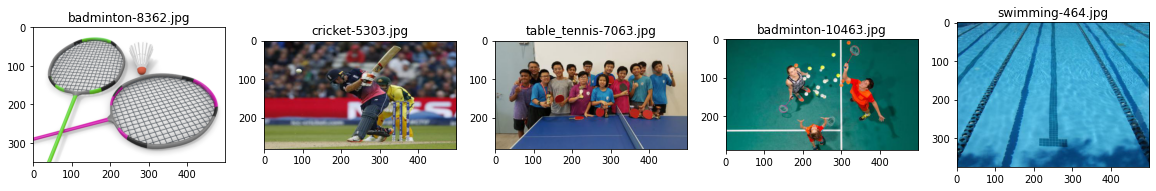

In [6]:
# Printing random five images
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(data_path))
    image_path = os.path.join(data_path, file)
    image_details = image_df[image_df['file'] == file]
    image_label = image_details.iloc[0]['label']
    label_name = []
    for key, value in labels.items():
        if value == image_label:
            label_name.append(key)
    image_name = label_name[0]
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text(str(image_name)+"-"+str(file))
    plt.imshow(img)

In [16]:
# create a function that transforms the features fit for a neural network

def neural_network_features(df):

    seventy_five = int(len(df)*0.75)
    # split the df 75%-25%
    train_df = df[:seventy_five]
    test_df = df[seventy_five:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape((8280, 64 * 64 * 3))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape((2760, 64 * 64 * 3))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)
    # create a validation set
    image_val = train_images[:1000]
    partial_image_train = train_images[1000:]
    
    label_val = train_labels[:1000]
    partial_label_train = train_labels[1000:]
    
    return image_val, partial_image_train, label_val, partial_label_train


# create a function that transforms the features fit for a testing a neural network

def neural_network_eval_features(df):

    seventy_five = int(len(df)*0.75)
    # split the df 75%-25%
    train_df = df[:seventy_five]
    test_df = df[seventy_five:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape((8280, 64 * 64 * 3))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape((2760, 64 * 64 * 3))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)

    
    return train_images, train_labels, test_images, test_labels

In [8]:
# create a function to run a simple neural network
def simple_neural_network(learning_rate, epochs):
    network = models.Sequential()
    network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
    network.add(layers.Dense(22, activation = 'softmax'))
    network.compile(optimizer=optimizers.SGD(lr=learning_rate), loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])
    history = network.fit(partial_image_train, partial_label_train, epochs=epochs, batch_size=128,
              validation_data = (image_val, label_val))
    accuracy = history.history['accuracy']
    accuracy = statistics.mean(accuracy) 
    results_list.append([learning_rate,accuracy])

In [10]:
# create a list of all of the learning rates to test with
learning_rate = [10e-3, 10e-4 , 10e-5, 10e-6, 10e-7, 10e-8]
results_list = []

# prepare the data for modeling
image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

# run the data through the model for all 6 learning rates to determine the best learning rate for future modeling
for lr in learning_rate:
    simple_neural_network(lr, 5)

Train on 7280 samples, validate on 1000 samples
Epoch 1/5
7280/7280 [==============================] - ETA: 0s - loss: 2.9170 - accuracy: 0.1294WARNING:tensorflow:From /Users/kenny/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
7280/7280 [==============================] - 3s 450us/sample - loss: 2.9170 - accuracy: 0.1294 - val_loss: 2.8597 - val_accuracy: 0.1450
Epoch 2/5
7280/7280 [==============================] - 3s 430us/sample - loss: 2.6997 - accuracy: 0.2052 - val_loss: 2.7328 - val_accuracy: 0.1850
Epoch 3/5
7280/7280 [==============================] - 3s 427us/sample - loss: 2.6033 - accuracy: 0.2400 - val_loss: 2.6419 - val_accuracy: 0.2000
Epoch 4/5
7280/7280 [==============================] - 

In [11]:
# reveiw the top 5 optimizer learning rates
best_optimizers = pd.DataFrame(results_list, columns =
                               ['Learning_Rate','Accuracy']).sort_values(by=['Accuracy'],
                                                         ascending=False).reset_index(drop = True)
best_optimizers.head()

,Learning_Rate,Accuracy
0,1.000000e-02,0.224973
1,1.000000e-03,0.143846
2,1.000000e-04,0.082390
3,1.000000e-05,0.050659
4,1.000000e-07,0.046868


I will proceed with using lr=0.01 for the rest of my models that use SGD for the optimizer

In [12]:
# create a function that plots the models performance for analysis
def plot_model(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
# create a list to store the results of the future models
modeling_results = []

Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 4s 562us/sample - loss: 2.9270 - accuracy: 0.1253 - val_loss: 2.8334 - val_accuracy: 0.1660
Epoch 2/30
7280/7280 [==============================] - 4s 518us/sample - loss: 2.6996 - accuracy: 0.2037 - val_loss: 2.7634 - val_accuracy: 0.1790
Epoch 3/30
7280/7280 [==============================] - 3s 469us/sample - loss: 2.5950 - accuracy: 0.2444 - val_loss: 2.6371 - val_accuracy: 0.2270
Epoch 4/30
7280/7280 [==============================] - 4s 506us/sample - loss: 2.5087 - accuracy: 0.2665 - val_loss: 2.6585 - val_accuracy: 0.2460
Epoch 5/30
7280/7280 [==============================] - 4s 516us/sample - loss: 2.4435 - accuracy: 0.2898 - val_loss: 2.6351 - val_accuracy: 0.2170
Epoch 6/30
7280/7280 [==============================] - 6s 860us/sample - loss: 2.3939 - accuracy: 0.3040 - val_loss: 2.6218 - val_accuracy: 0.2190
Epoch 7/30
7280/7280 [==============================] - 4s 491us

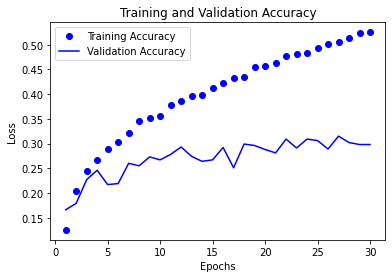

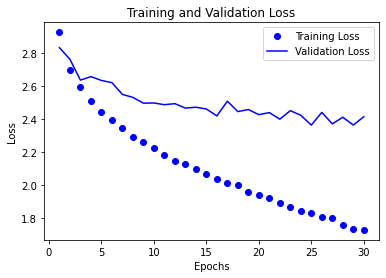

In [14]:
# Simple Neural Network

# run a model of a simple neural network with no optimization strategies

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 27 epochs with the best accuracy and lowest loss on the training data. I am going to run 27 epochs in test

In [17]:
# Evaluate the Simple Neural Network

train_images, train_labels, test_images, test_labels = neural_network_eval_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

network.fit(train_images, train_labels, epochs=27, batch_size=128, verbose = 0)

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN','SGD', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 31%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 5s 735us/sample - loss: 3.9170 - accuracy: 0.1317 - val_loss: 3.8457 - val_accuracy: 0.1240
Epoch 2/30
7280/7280 [==============================] - 5s 676us/sample - loss: 3.6823 - accuracy: 0.2003 - val_loss: 3.8240 - val_accuracy: 0.2060
Epoch 3/30
7280/7280 [==============================] - 5s 672us/sample - loss: 3.5677 - accuracy: 0.2416 - val_loss: 3.6322 - val_accuracy: 0.2160
Epoch 4/30
7280/7280 [==============================] - 5s 650us/sample - loss: 3.4886 - accuracy: 0.2702 - val_loss: 3.6155 - val_accuracy: 0.2170
Epoch 5/30
7280/7280 [==============================] - 5s 650us/sample - loss: 3.4217 - accuracy: 0.2905 - val_loss: 3.6178 - val_accuracy: 0.2100
Epoch 6/30
7280/7280 [==============================] - 5s 638us/sample - loss: 3.3576 - accuracy: 0.3168 - val_loss: 3.4779 - val_accuracy: 0.2560
Epoch 7/30
7280/7280 [==============================] - 5s 623us

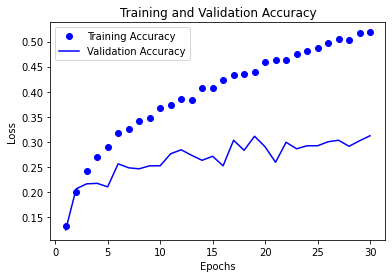

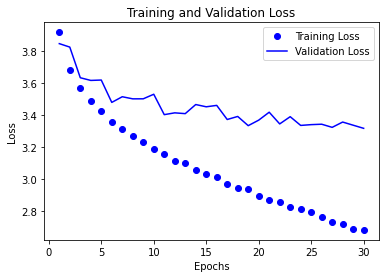

In [18]:
# Simple Neural Network with L2 Regularization Penalty

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 30 epochs with the best accuracy and lowest loss on the training data. I am going to run 30 epochs in test

In [19]:
# Evaluate the Simple Neural Network with L2 Regularization Penalty

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN L2 Reg','SGD', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 31%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 7s 943us/sample - loss: 69.3148 - accuracy: 0.1249 - val_loss: 67.4618 - val_accuracy: 0.1530
Epoch 2/30
7280/7280 [==============================] - 7s 925us/sample - loss: 65.6053 - accuracy: 0.2076 - val_loss: 64.0113 - val_accuracy: 0.1330
Epoch 3/30
7280/7280 [==============================] - 7s 1ms/sample - loss: 62.1217 - accuracy: 0.2277 - val_loss: 60.4970 - val_accuracy: 0.1950
Epoch 4/30
7280/7280 [==============================] - 5s 748us/sample - loss: 58.7393 - accuracy: 0.2655 - val_loss: 57.2559 - val_accuracy: 0.1880
Epoch 5/30
7280/7280 [==============================] - 6s 872us/sample - loss: 55.4869 - accuracy: 0.2854 - val_loss: 54.0739 - val_accuracy: 0.1950
Epoch 6/30
7280/7280 [==============================] - 6s 792us/sample - loss: 52.3444 - accuracy: 0.2904 - val_loss: 51.0338 - val_accuracy: 0.1990
Epoch 7/30
7280/7280 [==============================] 

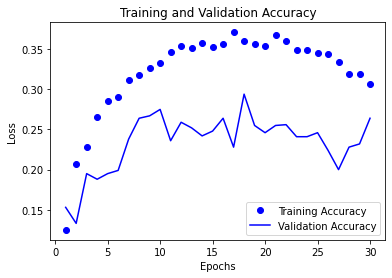

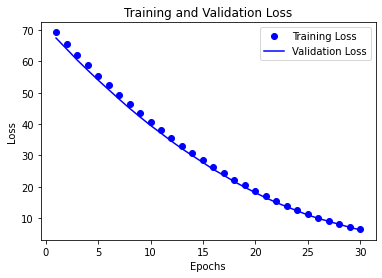

In [20]:
# Simple Neural Network with L1 Regularization Penalty

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001),
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 18 ephocs with the best accuracy and lowest loss on the training data. I am going to run 18 epochs in test

In [21]:
# Evaluate the Simple Neural Network with L1 Regularization Penalty - SGD

train_images, train_labels, test_images, test_labels = neural_network_eval_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001), 
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

network.fit(train_images, train_labels, epochs=18, batch_size=128, verbose = 0)

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN L1 Reg','SGD', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 30%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 6s 787us/sample - loss: 70.2516 - accuracy: 0.1254 - val_loss: 68.3446 - val_accuracy: 0.1330
Epoch 2/30
7280/7280 [==============================] - 6s 797us/sample - loss: 66.3890 - accuracy: 0.2012 - val_loss: 64.7087 - val_accuracy: 0.2050
Epoch 3/30
7280/7280 [==============================] - 6s 763us/sample - loss: 62.7525 - accuracy: 0.2433 - val_loss: 61.0925 - val_accuracy: 0.1950
Epoch 4/30
7280/7280 [==============================] - 6s 770us/sample - loss: 59.2638 - accuracy: 0.2595 - val_loss: 57.6903 - val_accuracy: 0.2200
Epoch 5/30
7280/7280 [==============================] - 5s 745us/sample - loss: 55.8818 - accuracy: 0.2867 - val_loss: 54.5635 - val_accuracy: 0.1610
Epoch 6/30
7280/7280 [==============================] - 6s 783us/sample - loss: 52.6368 - accuracy: 0.2919 - val_loss: 51.1930 - val_accuracy: 0.2350
Epoch 7/30
7280/7280 [==============================

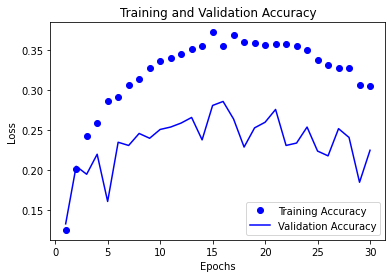

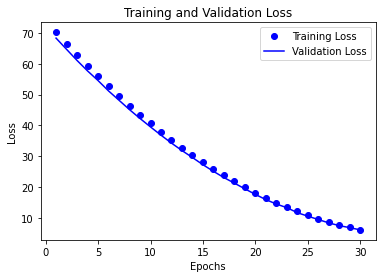

In [22]:
# Simple Neural Network with Simultaneous L1 and L2 Regularization Penalty

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 16 ephocs with the best accuracy and lowest loss on the training data. I am going to run 16 epochs in test

In [23]:
# Evaluate the Simultaneous L1 and L2 Regularization Penalty

train_images, train_labels, test_images, test_labels = neural_network_eval_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

network.fit(train_images, train_labels, epochs=16, batch_size=128, verbose = 0)

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN L1/L2 Reg','SGD', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 24%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 4s 523us/sample - loss: 3.0044 - accuracy: 0.1098 - val_loss: 2.8645 - val_accuracy: 0.1520
Epoch 2/30
7280/7280 [==============================] - 4s 510us/sample - loss: 2.8399 - accuracy: 0.1563 - val_loss: 2.7853 - val_accuracy: 0.1760
Epoch 3/30
7280/7280 [==============================] - 3s 438us/sample - loss: 2.7420 - accuracy: 0.1966 - val_loss: 2.7138 - val_accuracy: 0.2180
Epoch 4/30
7280/7280 [==============================] - 3s 460us/sample - loss: 2.6764 - accuracy: 0.2117 - val_loss: 2.6561 - val_accuracy: 0.2260
Epoch 5/30
7280/7280 [==============================] - 3s 398us/sample - loss: 2.6130 - accuracy: 0.2284 - val_loss: 2.6278 - val_accuracy: 0.2430
Epoch 6/30
7280/7280 [==============================] - 3s 405us/sample - loss: 2.5689 - accuracy: 0.2497 - val_loss: 2.5916 - val_accuracy: 0.2330
Epoch 7/30
7280/7280 [==============================] - 3s 411us

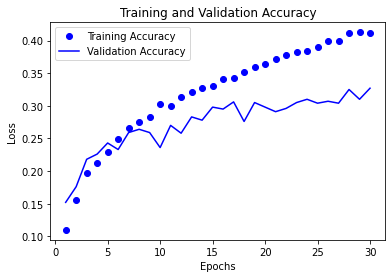

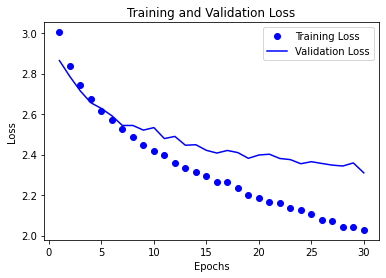

In [24]:
# Simple Neural Network with Dropout Penalty

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 28 ephocs with the best accuracy and lowest loss on the training data. I am going to run 28 epochs in test

In [25]:
# Evaluate the Simple Neural Network with Dropout Penalty

train_images, train_labels, test_images, test_labels = neural_network_eval_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

network.fit(train_images, train_labels, epochs=28, batch_size=128, verbose = 0)

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN Dropout','SGD', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 32%


In [26]:
# Review the results of all of the Simple Neural Network models and compare

pd.DataFrame(modeling_results, columns = ['Model_Type', 'Optimization',
                                          'Accuracy']).sort_values(by=['Accuracy'],
                                                                   ascending=False).reset_index(drop = True)

,Model_Type,Optimization,Accuracy
0,Simple NN Dropout,SGD,0.321014
1,Simple NN,SGD,0.314855
2,Simple NN L2 Reg,SGD,0.313406
3,Simple NN L1 Reg,SGD,0.298188
4,Simple NN L1/L2 Reg,SGD,0.238768


It looks like so far, the Neural Network model with a Dropout layer added in performed the best. Let's see what happpens when we start modeling with Convolutional Neural Networks and if the performance increase.

In [27]:
# create a function that transforms the features fit for a Convolutional Neural Network

def cnn_features(df):

    seventy_five = int(len(df)*0.75)
    # split the df 75%-25%
    train_df = df[:seventy_five]
    test_df = df[seventy_five:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape((8280, 64, 64, 3))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape((2760, 64, 64, 3))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)
    # create a validation set
    image_val = train_images[:1000]
    partial_image_train = train_images[1000:]
    
    label_val = train_labels[:1000]
    partial_label_train = train_labels[1000:]
    
    return image_val, partial_image_train, label_val, partial_label_train


# create a function that transforms the features fit for a testing a Convolutional Neural Network

def cnn_eval_features(df):

    seventy_five = int(len(df)*0.75)
    # split the df 75%-25%
    train_df = df[:seventy_five]
    test_df = df[seventy_five:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape((8280, 64, 64, 3))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape((2760, 64, 64, 3))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)

    
    return train_images, train_labels, test_images, test_labels

In [28]:
# create a function to run a CNN

cnn_results_list = []

def test_CNN(learning_rate, epochs):   
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(64,64,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(22, activation = 'softmax'))

    model.compile(optimizer=optimizers.SGD(lr=learning_rate), loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    history = model.fit(partial_image_train, partial_label_train, epochs=epochs, batch_size=128,
                        validation_data = (image_val, label_val))
    
    accuracy = history.history['accuracy']
    accuracy = statistics.mean(accuracy) 
    cnn_results_list.append([learning_rate,accuracy])

In [29]:
# create a list of all of the learning rates to test with
learning_rate = [10e-3, 10e-4 , 10e-5, 10e-6, 10e-7, 10e-8]

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

# run the data through the model for all 6 learning rates to determine the best learning rate for future modeling

for lr in learning_rate:
    test_CNN(lr, 5)

Train on 7280 samples, validate on 1000 samples
Epoch 1/5
7280/7280 [==============================] - 53s 7ms/sample - loss: 3.0868 - accuracy: 0.0532 - val_loss: 3.0877 - val_accuracy: 0.0440
Epoch 2/5
7280/7280 [==============================] - 48s 7ms/sample - loss: 3.0773 - accuracy: 0.0684 - val_loss: 3.0825 - val_accuracy: 0.0650
Epoch 3/5
7280/7280 [==============================] - 33s 5ms/sample - loss: 3.0705 - accuracy: 0.0749 - val_loss: 3.0785 - val_accuracy: 0.0590
Epoch 4/5
7280/7280 [==============================] - 34s 5ms/sample - loss: 3.0644 - accuracy: 0.0777 - val_loss: 3.0739 - val_accuracy: 0.0560
Epoch 5/5
7280/7280 [==============================] - 30s 4ms/sample - loss: 3.0584 - accuracy: 0.0694 - val_loss: 3.0686 - val_accuracy: 0.0630
Train on 7280 samples, validate on 1000 samples
Epoch 1/5
7280/7280 [==============================] - 31s 4ms/sample - loss: 3.0934 - accuracy: 0.0339 - val_loss: 3.0925 - val_accuracy: 0.0380
Epoch 2/5
7280/7280 [=======

In [30]:
best_optimizers = pd.DataFrame(cnn_results_list, columns =
                               ['Learning_Rate','Accuracy']).sort_values(by=['Accuracy'],
                                                                         ascending=False).reset_index(drop = True)
best_optimizers.head()

,Learning_Rate,Accuracy
0,1.000000e-02,0.068709
1,1.000000e-04,0.065110
2,1.000000e-05,0.051374
3,1.000000e-06,0.042857
4,1.000000e-07,0.041071


I will process with using lr=0.01 for the rest of my models that use SGD for the optimizer

Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 41s 6ms/sample - loss: 3.0844 - accuracy: 0.0610 - val_loss: 3.0857 - val_accuracy: 0.0550
Epoch 2/30
7280/7280 [==============================] - 32s 4ms/sample - loss: 3.0759 - accuracy: 0.0657 - val_loss: 3.0804 - val_accuracy: 0.0550
Epoch 3/30
7280/7280 [==============================] - 32s 4ms/sample - loss: 3.0684 - accuracy: 0.0657 - val_loss: 3.0764 - val_accuracy: 0.0550
Epoch 4/30
7280/7280 [==============================] - 32s 4ms/sample - loss: 3.0615 - accuracy: 0.0657 - val_loss: 3.0717 - val_accuracy: 0.0550
Epoch 5/30
7280/7280 [==============================] - 32s 4ms/sample - loss: 3.0542 - accuracy: 0.0658 - val_loss: 3.0649 - val_accuracy: 0.0570
Epoch 6/30
7280/7280 [==============================] - 33s 5ms/sample - loss: 3.0455 - accuracy: 0.0652 - val_loss: 3.0563 - val_accuracy: 0.0570
Epoch 7/30
7280/7280 [==============================] - 33s 5ms/sample

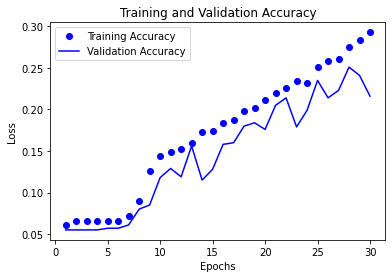

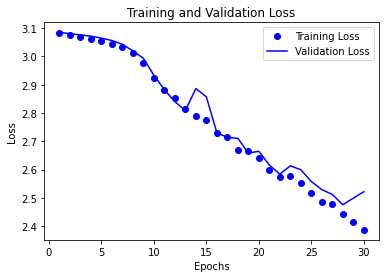

In [31]:
# Convolutional Neural Network

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(64,64,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(22, activation = 'softmax'))

model.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 30 with the best accuracy and lowest loss, so I am going to run 30 epochs in test

In [32]:
# Evaluate the Convolutional Neural Network

train_images, train_labels, test_images, test_labels = cnn_eval_features(image_df)

test_loss, test_acc = model.evaluate(test_images, test_labels)
modeling_results.append(['Simple CNN','SGD', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 26%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 33s 5ms/sample - loss: 3.0890 - accuracy: 0.0479 - val_loss: 3.0831 - val_accuracy: 0.0580
Epoch 2/30
7280/7280 [==============================] - 31s 4ms/sample - loss: 3.0833 - accuracy: 0.0595 - val_loss: 3.0797 - val_accuracy: 0.0560
Epoch 3/30
7280/7280 [==============================] - 31s 4ms/sample - loss: 3.0780 - accuracy: 0.0617 - val_loss: 3.0771 - val_accuracy: 0.0580
Epoch 4/30
7280/7280 [==============================] - 30s 4ms/sample - loss: 3.0755 - accuracy: 0.0637 - val_loss: 3.0746 - val_accuracy: 0.0690
Epoch 5/30
7280/7280 [==============================] - 36s 5ms/sample - loss: 3.0713 - accuracy: 0.0648 - val_loss: 3.0729 - val_accuracy: 0.0630
Epoch 6/30
7280/7280 [==============================] - 31s 4ms/sample - loss: 3.0682 - accuracy: 0.0698 - val_loss: 3.0700 - val_accuracy: 0.0570
Epoch 7/30
7280/7280 [==============================] - 30s 4ms/sample

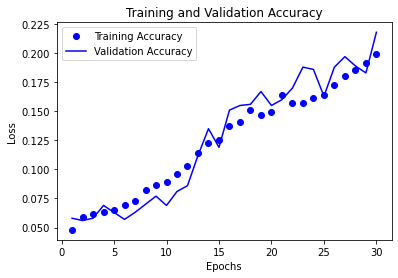

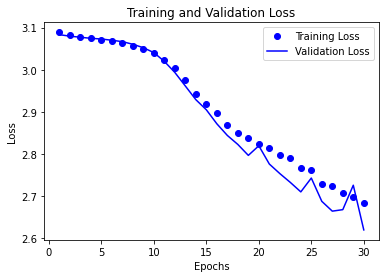

In [33]:
# Convolutional Neural Network with Dropout

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(64,64,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(22, activation = 'softmax'))

model.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 30 with the best accyracy and lowest loss, so I am going to run 30 epochs in test

In [34]:
# Evaluate the Convolutional Neural Network with Dropout - SGD

train_images, train_labels, test_images, test_labels = cnn_eval_features(image_df)

test_loss, test_acc = model.evaluate(test_images, test_labels)
modeling_results.append(['CNN w/Dropout','SGD', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 22%


Epoch 1/30
100/100 [==============================] - 14s 136ms/step - batch: 49.5000 - size: 20.0000 - loss: 3.0904 - accuracy: 0.0555 - val_loss: 3.0848 - val_accuracy: 0.0590
Epoch 2/30
100/100 [==============================] - 12s 125ms/step - batch: 49.5000 - size: 20.0000 - loss: 3.0815 - accuracy: 0.0665 - val_loss: 3.0796 - val_accuracy: 0.0550
Epoch 3/30
100/100 [==============================] - 13s 127ms/step - batch: 49.5000 - size: 20.0000 - loss: 3.0705 - accuracy: 0.0670 - val_loss: 3.0752 - val_accuracy: 0.0610
Epoch 4/30
100/100 [==============================] - 12s 125ms/step - batch: 49.5000 - size: 20.0000 - loss: 3.0717 - accuracy: 0.0585 - val_loss: 3.0698 - val_accuracy: 0.0970
Epoch 5/30
100/100 [==============================] - 13s 127ms/step - batch: 49.5000 - size: 20.0000 - loss: 3.0648 - accuracy: 0.0660 - val_loss: 3.0640 - val_accuracy: 0.0620
Epoch 6/30
100/100 [==============================] - 13s 126ms/step - batch: 49.5000 - size: 20.0000 - loss: 

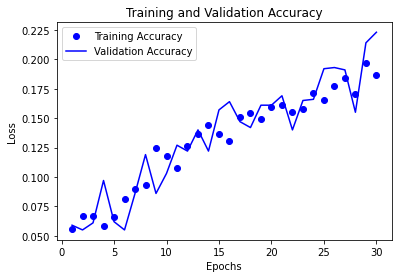

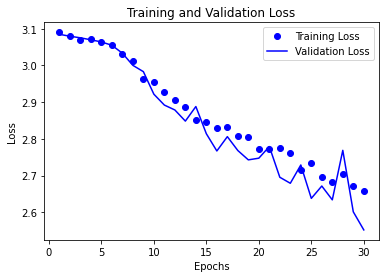

In [35]:
# Convolutional Neural Network with Data Augmentation and Dropout

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(64,64,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(22, activation = 'softmax'))

train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')#,rescale=1./255)

train_generator = train_datagen.flow(partial_image_train, partial_label_train, batch_size=20)

model.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator, steps_per_epoch=100, epochs=30, validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 30 with the best accuracy and lowest loss, so I am going to run 30 epochs in test

In [36]:
# Evaluate Convolutional Neural Network with Data Augmentation and Dropout

train_images, train_labels, test_images, test_labels = cnn_eval_features(image_df)

test_loss, test_acc = model.evaluate(test_images, test_labels)
modeling_results.append(['CNN with Dropout and Data Augmention','SGD', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 22%


Epoch 1/30
100/100 [==============================] - 92s 917ms/step - batch: 49.5000 - size: 20.0000 - loss: 2.8333 - accuracy: 0.1730 - val_loss: 2.4619 - val_accuracy: 0.2330
Epoch 2/30
100/100 [==============================] - 94s 941ms/step - batch: 49.5000 - size: 20.0000 - loss: 2.3407 - accuracy: 0.3165 - val_loss: 2.1476 - val_accuracy: 0.3760
Epoch 3/30
100/100 [==============================] - 106s 1s/step - batch: 49.5000 - size: 20.0000 - loss: 2.1979 - accuracy: 0.3470 - val_loss: 1.9513 - val_accuracy: 0.4250
Epoch 4/30
100/100 [==============================] - 99s 991ms/step - batch: 49.5000 - size: 20.0000 - loss: 1.9816 - accuracy: 0.4095 - val_loss: 1.8554 - val_accuracy: 0.4270
Epoch 5/30
100/100 [==============================] - 93s 931ms/step - batch: 49.5000 - size: 20.0000 - loss: 1.8878 - accuracy: 0.4225 - val_loss: 1.9135 - val_accuracy: 0.4170
Epoch 6/30
100/100 [==============================] - 96s 955ms/step - batch: 49.5000 - size: 20.0000 - loss: 1.

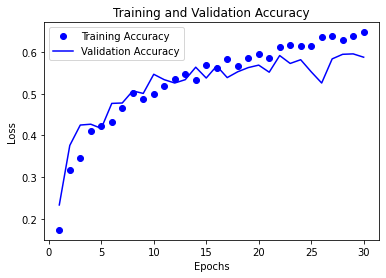

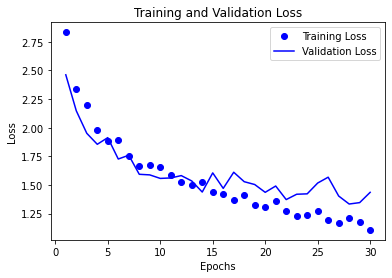

In [37]:
# Convolutional Neural Network with Pretrained Covnet (VGG16) Fine Tuning

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(22, activation = 'softmax'))

train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(partial_image_train, partial_label_train, batch_size=20)

model.compile(optimizer=optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(train_generator, steps_per_epoch=100, epochs=30,
                    validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 30 with the best accuracy and lowest loss, so I am going to run 30 epochs in test

In [38]:
# Evaluate Convolutional Neural Network with Pretrained Covnet (VGG16) Fine Tuning

train_images, train_labels, test_images, test_labels = cnn_eval_features(image_df)

test_loss, test_acc = model.evaluate(test_images, test_labels)
modeling_results.append(['VGG16','SGD', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 60%


In [41]:
sgd = pd.DataFrame(modeling_results, columns = ['Model_Type', 'Optimization',
                                          'Accuracy']).sort_values(by=['Accuracy'],
                                                                   ascending=False).reset_index(drop = True)
sgd.to_csv('sgd.csv', index=False)

sgd

,Model_Type,Optimization,Accuracy
0,VGG16,SGD,0.596739
1,Simple NN Dropout,SGD,0.321014
2,Simple NN,SGD,0.314855
3,Simple NN L2 Reg,SGD,0.313406
4,Simple NN L1 Reg,SGD,0.298188
5,Simple CNN,SGD,0.257246
6,Simple NN L1/L2 Reg,SGD,0.238768
7,CNN with Dropout and Data Augmention,SGD,0.223188
8,CNN w/Dropout,SGD,0.218116
